In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,r2quat,compute_view_params,get_interp_const_vel_traj, printmd
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline


In [2]:
print ("MuJoCo version:[%s]"%(mujoco.__version__))
xml_path = '../../../asset/visualize_realworld_wo_shelf_pringles.xml'
env = MuJoCoParserClass(name='Place task scene: Office table',rel_xml_path=xml_path,VERBOSE=False, MODE='window')
print(env.MODE)

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0])
env.model.body('avoiding_object_table').pos = np.array([0.38+0.45,0,0])
env.model.body('base').pos = np.array([0.18,0,0.79])
env.model.body('right_object_table').pos = np.array([-0.05,-0.80,0])
env.model.body('left_object_table').pos = np.array([-0.05,0.80,0])

# Place objects
tray_pos = np.array([ 0.9, 0.25, 0.8])
tray_gray_pos = np.array([ 0.9, 0., 0.8])
bowl_red_pos = np.array([ 0.9, -0.25, 0.8])
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[:3] = tray_pos
env.model.joint(env.model.body('tray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[:3] = tray_gray_pos
env.model.joint(env.model.body('tray_gray').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, 0, 90])))
env.model.joint(env.model.body('kitchen-bowl-red').jntadr[0]).qpos0[:3] = bowl_red_pos

env.model.joint(env.model.body('ycb-apple-2').jntadr[0]).qpos0[:3] = bowl_red_pos + np.array([0,0,0.1])
env.model.joint(env.model.body('mug_cup').jntadr[0]).qpos0[:3] = tray_pos + np.array([0.05,0,0.05])
env.model.joint(env.model.body('hershey_cookie').jntadr[0]).qpos0[:3] = tray_gray_pos + np.array([0.05,0,0.05])
env.model.joint(env.model.body('hershey_cookie').jntadr[0]).qpos0[3:] = r2quat(rpy2r(np.radians([90, -90, 0])))

env.model.joint(env.model.body('kitchen-bowl-blue').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])
env.model.joint(env.model.body('ycb-banana-2').jntadr[0]).qpos0[:3] = np.array([-9,0,0]) # sorted_pose[2] + spawn_z_offset
env.model.joint(env.model.body('ycb-lemon-2').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])
env.model.joint(env.model.body('ycb-orange-2').jntadr[0]).qpos0[:3] = np.array([-5,0,0.5])

# Target objects
env.model.joint(env.model.body('pringles').jntadr[0]).qpos0[:3] = np.array([0.1, -0.6, 0.8])

MuJoCo version:[2.3.7]
window


In [4]:

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Reset
env.reset()
init_ur_q = np.array([np.deg2rad(-180), np.deg2rad(-30), np.deg2rad(-120), np.deg2rad(125), np.deg2rad(-90), np.deg2rad(0)])

env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000

i = 0

while env.get_sim_time() <= max_sec:    
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    # env.model.geom_size[env.model.body('obj_box_03').geomadr[0]] += np.array([0.0001,0.0001,0.0001])
    if not env.is_viewer_alive(): break

    # Render
    if env.loop_every(HZ=100):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2] # + np.array([0,0,-0.2])
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=40,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
        env.render(render_every=1)

# Close viewer
env.close_viewer()

[ 0.35 -0.13  1.16]
Pressed ESC
Quitting.


In [4]:
def uniform_sample_position(x_range, y_range, z_range, n_sample):
    x_values = np.linspace(x_range[0], x_range[1], 10)
    y_values = np.linspace(y_range[0], y_range[1], 10)
    z_values_floor1 = np.linspace(z_range[0], 1.2, 5)
    z_values_floor2 = np.linspace(1.2, z_range[1], 5)
    
    positions = []
    for x in x_values:
        for y in y_values:
            for z1 in z_values_floor1:  # 1st floor
                positions.append((x, y, z1))
            for z2 in z_values_floor2:  # 2nd floor
                positions.append((x, y, z2))
    
    return np.array(positions)

x_range = np.array([0.4, 1.25])
y_range = np.array([-0.55, 0.55])
# 0.8m: 1st floor, 0.8m: 2nd floor
z_range = np.array([0.8, 1.5])

n_sample = 15
uniform_positions = uniform_sample_position(x_range, y_range, z_range, n_sample)
uniform_positions.shape

(1000, 3)

In [5]:
def get_geom_region_type8(env, obj_name):
    center_x, center_y, center_z, size_w, size_h, size_d = env.model.geom_aabb[env.model.body(obj_name).geomadr][0]
    obj_pos_x, obj_pos_y, obj_pos_z = env.get_p_body(obj_name)
    obj_R = env.get_R_body(obj_name)
    
    # Get the corners of the object based on the lower corner
    corners = np.array([
        # [center_x - size_w, center_y - size_h, center_z - size_d],
        # [center_x - 1*size_w, center_y - size_h, center_z + size_d],
        [center_x - size_w, center_y + size_h, center_z - size_d],
        [center_x - 1*size_w, center_y + size_h, center_z + size_d],
        # [center_x + size_w, center_y - size_h, center_z - size_d],
        # [center_x + 1*size_w, center_y - size_h, center_z + size_d],
        [center_x + size_w, center_y + size_h, center_z - size_d],
        [center_x + 1*size_w, center_y + size_h, center_z + size_d],
    ])
    
    # Consider Rotation and Translation of the obj_name
    corners = np.matmul(corners, obj_R.T) + np.array([obj_pos_x, obj_pos_y, obj_pos_z])

    return corners


[ 0.5  -0.01  1.16]
Pressed ESC
Quitting.


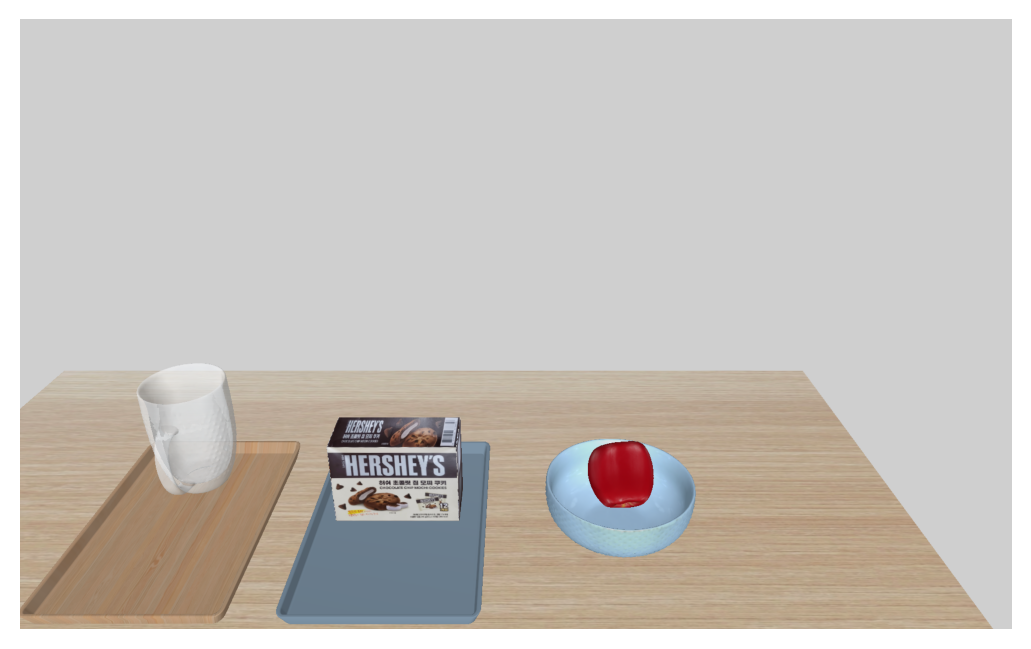

Done. Tick:[1102] Time:[2.20]sec


In [6]:
from utils.util import fill_object, get_geom_region_type1, get_geom_region_type2, get_geom_region_type3, get_geom_region_type4

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=30,distance=3.0,elevation=-30,lookat=[1.0,0.0,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

target_obj_jntadr = env.model.body('redbullcan').jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

# Reset
env.reset()
# init_ur_q = np.array([0,0,0,0,np.deg2rad(90),0])
init_ur_q = np.array([np.deg2rad(-90), np.deg2rad(-130), np.deg2rad(120), np.deg2rad(100), np.deg2rad(45), np.deg2rad(-90)])
env.forward(q=init_ur_q, joint_idxs=env.idxs_forward)
initial_xyz = env.get_p_body('tcp_link')
print(env.get_p_body('tcp_link'))
tick,max_sec = 0,1000
while env.get_sim_time() <= max_sec:
    env.step(ctrl=init_ur_q,ctrl_idxs=env.idxs_step)
    if not env.is_viewer_alive(): break
        
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = np.array([0.8, 0.8, 1.0])
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([90, 0, 0])))
    # Render
    if env.loop_every(HZ=20):
        # Example bounding box data (center, size)
        resolution = (10, 10, 5)  # Number of points along each axis
        points = fill_object(get_geom_region_type8(env, 'tray'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type4(env, 'tray_gray'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]
        points = fill_object(get_geom_region_type1(env, 'kitchen-bowl-red'), resolution)
        [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0.,0,1]) for sampled_place_ in points]

        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row1')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row2')]
        # [env.plot_sphere(p=sampled_place_, r=0.005, rgba=[1,0,0,1]) for sampled_place_ in get_geom_region_type1(env, 'shelf_row3')]

        env.render(render_every=1)
        

plt.imshow(rgb_img) 
plt.axis('off')
plt.show()

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

In [7]:
p_feas = np.load('./data_tray/feasible_pcd_20230915_c48_g4_worker48.npy')

In [15]:
import time

# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True, MODE='window')
env.update_viewer(azimuth=0.,distance=1.5,elevation=-80,lookat=([0.44, 0.  , 1.33]),
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=False,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

env.reset()
# Start from initial configuration
capture_pose_q = np.array([np.deg2rad(-90), np.deg2rad(-132.46), np.deg2rad(122.85), np.deg2rad(99.65), np.deg2rad(45), np.deg2rad(-90.02)])
init_configurations = [-0.73418, -1.08485, 2.7836, -1.699, 0.8366, 0]
env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])

tick = 0
end_tick = 1000
target_obj_name = 'pringles' # 'coke'
target_cylinder_jntadr = env.model.body(target_obj_name).jntadr[0]
print(env.get_p_body(target_obj_name)[0])
p_list = []
R_list = []
feasible_place_positions = []
target_obj_jntadr = env.model.body(target_obj_name).jntadr[0]
target_obj_qposadr = env.model.jnt_qposadr[target_obj_jntadr]

env.set_figure(fig_idx=0, line_name="x", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="y", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=0, line_name="z", title="Joint position", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Roll", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Pitch", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=1, line_name="Yaw", title="Rotation", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
env.set_figure(fig_idx=2, line_name="Q_w", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_x", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_y", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)
# env.set_figure(fig_idx=2, line_name="Q_z", title="Quat", xlabel="Time [sec]", rgba=[0,0,0,0], gridsize=(5,5), legend=True)

perturb_tick = 500

for p in p_feas[::5]:
    p_list = []
    R_list = []
    quat_list = []
    p += np.array([0, 0, 0.07])
    print(f"Position: {p}")
    start = env.tick
    p_copy = p
    env.data.qpos[target_obj_qposadr:target_obj_qposadr+3] = p_copy
    env.data.qpos[target_obj_qposadr+3:target_obj_qposadr+7] = r2quat(rpy2r(np.radians([90, 0, 0])))
    while env.tick - start < end_tick:
        # if env.tick - start > perturb_tick:
        #     noise = np.random.normal(0, 0.001, 4)
        #     env.data.qpos[target_obj_qposadr+3: target_obj_qposadr+7] += noise

        if not env.is_viewer_alive(): break
        env.forward(q=capture_pose_q,joint_idxs=[0,1,2,3,4,5])
        env.step(ctrl=capture_pose_q,ctrl_idxs=[0,1,2,3,4,5])
        R_obj = env.get_R_body(target_obj_name)
        quat_ = r2quat(R_obj)
        quat_list.append(quat_)
        env.plot_sphere(p=p_copy, r=0.005, rgba=[0,1,0,1], label=f"{env.tick}/{end_tick}")
        [env.plot_sphere(p=sampled_place_+[0,0,0.05], r=0.005, rgba=[0.7,0,0.7,0.1]) for sampled_place_ in p_feas]

        env.plot_data(name="x", data=np.array(env.get_p_body(target_obj_name))[0], fig_idx=0)
        env.plot_data(name="y", data=np.array(env.get_p_body(target_obj_name))[1], fig_idx=0)
        env.plot_data(name="z", data=np.array(env.get_p_body(target_obj_name))[2], fig_idx=0)

        env.plot_data(name="Roll", data=r2rpy(env.get_R_body(target_obj_name))[0], fig_idx=1)
        env.plot_data(name="Pitch", data=r2rpy(env.get_R_body(target_obj_name))[1], fig_idx=1)
        env.plot_data(name="Yaw", data=r2rpy(env.get_R_body(target_obj_name))[2], fig_idx=1)
 
        env.plot_data(name="Q_w", data=env.data.qpos[target_obj_qposadr+3], fig_idx=2)
        # env.plot_data(name="Q_x", data=env.data.qpos[target_obj_qposadr+4], fig_idx=2)
        # env.plot_data(name="Q_y", data=env.data.qpos[target_obj_qposadr+5], fig_idx=2)
        # env.plot_data(name="Q_z", data=env.data.qpos[target_obj_qposadr+6], fig_idx=2)

        env.render(render_every=5)

    if not env.is_viewer_alive(): break    
    env.reset()
    lower_bound = 0.70
    upper_bound = 0.79
    in_range = np.logical_and(np.array(quat_list)[5:][:,0] >= lower_bound, np.array(quat_list)[5:][:,0] <= upper_bound)
    all_in_range = np.all(in_range)
    # print(f"all_in_range: {all_in_range}")
    print(f"max_qw: {np.max(np.array(quat_list)[5:][:,0])}")
    print(f"min_qw: {np.min(np.array(quat_list)[5:][:,0])}")

# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

0.1
Position: [0.75 0.14 1.18]
Pressed ESC
Quitting.
Done. Tick:[13] Time:[0.01]sec


### LLM screening

### Interact with GPT

In [10]:
import os
import openai
import sys
sys.path.append('../../../')
from utils.gpt_helper import set_openai_api_key_from_txt,GPTchatClass,printmd
from utils.wiki_helper import wiki_search
from utils.util import printmd,extract_quoted_words
print ("openai version:[%s]"%(openai.__version__))

openai version:[0.27.8]


In [11]:
import openai
openai.api_key = 'your key' 
model_name = 'gpt-3.5-turbo'#'text-davinci-002' # CaP uses text-davinci-002

class ChatGPT():
    def __init__ (self, system_prompt, model_engine='text-davinci-003'):
        self.model_engine = model_engine
        self.system_prompt = system_prompt
        self.msg_history_davinci = self.system_prompt
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]
        self.role = 'user'
    
    def reset(self):
        self.msg_history_turbo = [{"role": "assistant", "content": self.system_prompt}]

    def get_answer(self, prompt=None):
        if self.model_engine == 'gpt-3.5-turbo':
            self.msg_history_turbo.append({"role": self.role, "content":prompt})
            response   = openai.ChatCompletion.create(
            model      = self.model_engine,
            temperature= 0.9,
            messages   = self.msg_history_turbo)
            reply_text = response['choices'][0]['message']['content']
            self.msg_history_turbo.append({"role":"assistant", "content":reply_text})

        elif self.model_engine == 'text-davinci-003': 
            self.msg_history_davinci += "You: "+prompt 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = self.msg_history_davinci,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            #stop       = ["You:", "AI:"]
            )
            reply_text = response.choices[0].text.strip().replace('Answer: ', '')
            self.msg_history_davinci+="\n"+"AI: "+reply_text+"\n"

        elif self.model_engine == 'text-davinci-002': 
            response   = openai.Completion.create(
            engine     = self.model_engine,
            prompt     = prompt,
            max_tokens = 512,
            temperature= 1.0,
            n          = 1,
            )
            reply_text = response['choices'][0]['text'].strip()
        return reply_text



#### Similarity a) color

In [16]:
object_description_list = ["glass mug cup", "hershey choco snack", "apple"]
target_object_name = ["pringles"]

user_msg = \
    f"""
    Scene description:
    In the woody tray: there is a mug cup.
    In the gray tray: there is a hershey choco snack.
    In the blue bowl: there is an apple.
    
    Task description: 
    The task is to place the {target_object_name[0]} on the table in best fit region with it's genre.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it with the {target_object_name[0]}.
        I want to place the {target_object_name[0]} with the same color of the {target_object_name[0]}.
        In the woody tray: there is a glass wine.
        In the gray tray: there is an Oreo cookie.
        In the blue bowl: there is an apple.
    GPT-4: [Recommended region: Next to the Apple in the third level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    """

printmd(user_msg)


    Scene description:
    In the woody tray: there is a mug cup.
    In the gray tray: there is a hershey choco snack.
    In the blue bowl: there is an apple.
    
    Task description: 
    The task is to place the pringles on the table in best fit region with it's genre.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it with the pringles.
        I want to place the pringles with the same color of the pringles.
        In the woody tray: there is a glass wine.
        In the gray tray: there is an Oreo cookie.
        In the blue bowl: there is an apple.
    GPT-4: [Recommended region: Next to the Apple in the third level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    

In [17]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [18]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

I understand. Let's start the simulation.

In [23]:
user_msg = \
    f"""
    Let me know which tray or bowl is suitable to place it? Only you can say the region.
    I want to place the {target_object_name[0]} with the same color property. Say where is the best fit placement region?
    In the woody tray: there is a mug cup.
    In the gray tray: there is a hershey choco snack.
    In the blue bowl: there is an apple.
    """
printmd(user_msg)


    Let me know which tray or bowl is suitable to place it? Only you can say the region.
    I want to place the pringles with the same color property. Say where is the best fit placement region?
    In the woody tray: there is a mug cup.
    In the gray tray: there is a hershey choco snack.
    In the blue bowl: there is an apple.
    

In [24]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

Based on the color property, the best fit placement region for the Pringles would be the blue bowl, as it has a similar color to the Pringles packaging.

#### Similarity b) material property

In [25]:
object_description_list = ["glass mug cup", "cider", "apple", "pocky"]
target_object_name = ["pringles"]

user_msg = \
    f"""
    Scene description:
    In the first level of bookshelf: there is a glass mug cup.
    In the second level of bookshelf: there are cider and apple in the bookshelf.
    In the third level of bookshelf: there is a pocky in the bookshelf.
    
    Task description: 
    The task is to place the {target_object_name[0]} on the table in best fit region with it's genre.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it with the {target_object_name[0]} same material property of the {target_object_name[0]}.
        In the first level bookshelf: [sprite]
        In thw second level bookshelf: [oreo, fanta, orange]
        In the third level bookshelf: [chocopie]
    GPT-4: [Recommended region: Next to the chocopie in the third level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    """

In [ ]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [ ]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

I understand. I will provide you with the recommended region to place the Pringles based on its material property.

In [ ]:
user_msg = \
    f"""
    Let me know which region(area) is suitable to place it with the {target_object_name[0]} same material property of the {target_object_name[0]}.
    In the first level bookshelf: [glass mug cup]
    In thw second level bookshelf: [cider, apple]
    In the third level bookshelf: [pocky]
    """

In [ ]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

Based on the material property of the Pringles, which is a snack item, I would recommend placing the Pringles next to the Pocky in the third level of the bookshelf.

#### Similarity c) Shape

In [ ]:
object_description_list = ["glass mug cup", "cider", "apple", "pocky"]
target_object_name = ["pringles"]

user_msg = \
    f"""
    Scene description:
    In the first level of bookshelf: there is a glass mug cup.
    In the second level of bookshelf: there are cider and apple in the bookshelf.
    In the third level of bookshelf: there is a pocky in the bookshelf.
    
    Task description: 
    The task is to place the {target_object_name[0]} on the table in best fit region with it's genre.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it with the {target_object_name[0]}.
        I want to place the {target_object_name[0]} with the same color of the {target_object_name[0]}.
        In the first level bookshelf: [sprite]
        In thw second level bookshelf: [oreo, fanta, orange]
        In the third level bookshelf: [chocopie]
    GPT-4: [Recommended region: Next to the chocopie in the third level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    """

In [ ]:
printmd(user_msg)


    Scene description:
    In the first level of bookshelf: there is a glass mug cup.
    In the second level of bookshelf: there are cider and apple in the bookshelf.
    In the third level of bookshelf: there is a pocky in the bookshelf.
    
    Task description: 
    The task is to place the pringles on the table in best fit region with it's genre.

    This is an example of instruction. For example, answer the output following instructions.

    User: Let me know which region(area) is suitable to place it with the pringles.
        I want to place the pringles with the same color of the pringles.
        In the first level bookshelf: [sprite]
        In thw second level bookshelf: [oreo, fanta, orange]
        In the third level bookshelf: [chocopie]
    GPT-4: [Recommended region: Next to the chocopie in the third level bookshelf]

    If you understand, Say "I understand" and I will start the simulation.
    

In [ ]:
llm = ChatGPT(user_msg, model_engine=model_name)
llm.reset()

In [ ]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

I understand. Let's begin the simulation.

In [ ]:
user_msg = \
    f"""
    Let me know which level of bookshelf is suitable to place it? Only you can say the region.
    I want to place the {target_object_name[0]} with the same shape. Say where is the best fit placement region?
    In the first level bookshelf: [glass mug cup]
    In thw second level bookshelf: [cider, apple]
    In the third level bookshelf: [pocky]
    """

In [ ]:
response_content = llm.get_answer(prompt=user_msg)
printmd(response_content)

Based on the shape property, the best fit placement region for the Pringles would be on the first level of the bookshelf, next to the glass mug cup.

### Test on `the phyiscally plausible place`

In [ ]:
def remove_duplicates_with_specific_com(p_com, pointcloud, threshold=0.05):
    filtered_pointcloud = []
    
    for point in pointcloud:
        # Check if the point is close to the specific center of mass (p_com)
        if np.linalg.norm(np.array(point) - np.array(p_com)) < threshold:
            filtered_pointcloud.append(point)
            
    return np.array(filtered_pointcloud)

region_row2 = env.get_p_body('pocky')
region_row2 = env.get_p_body('mug_cup')
row2_pcd = remove_duplicates_with_specific_com(region_row2, p_feas, threshold=0.15)
row2_pcd.shape

(14, 3)

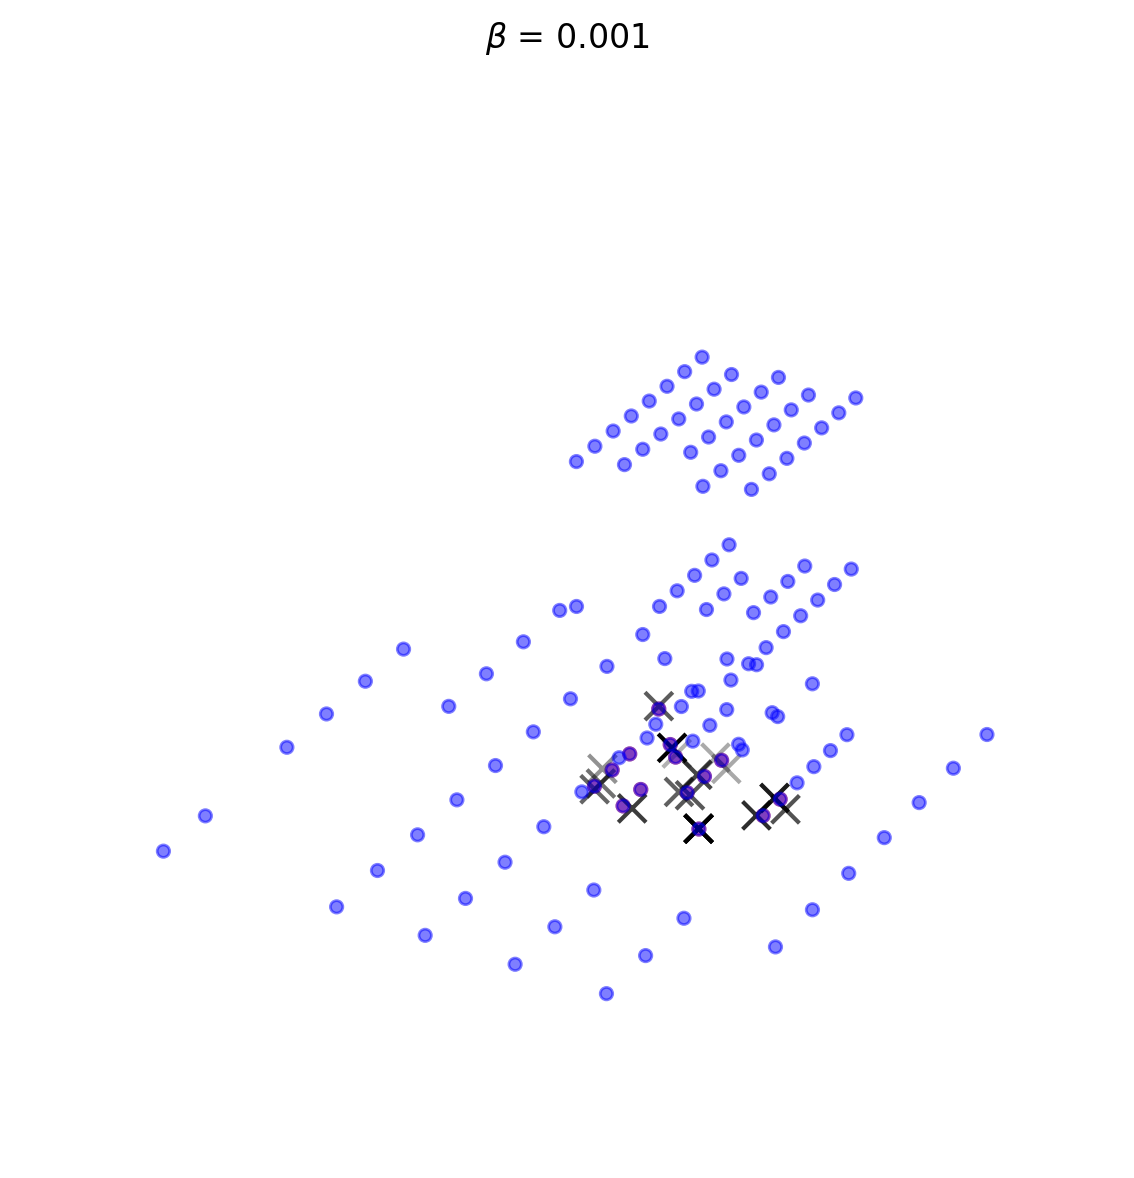

In [ ]:
from scipy.stats import gaussian_kde

# Adjust the function to sample from 3D KDE with scaling and debugging
def sample_from_kde_3d_scaled(pcd, kde_values, num_samples=10):
    kde_values_flat = kde_values.flatten()
    kde_sum = np.sum(kde_values_flat)
    
    if np.isclose(kde_sum, 0):
        print(f"Warning: Sum of KDE values is close to zero ({kde_sum})")
        return None

    kde_values_norm = kde_values_flat / kde_sum
    sampled_indices = np.random.choice(len(kde_values_flat), size=num_samples, p=kde_values_norm)
    sampled_coords = np.array(np.unravel_index(sampled_indices, kde_values.shape)).T
    
    # Scale to the actual range of the data
    x_range = np.linspace(pcd[:, 0].min(), pcd[:, 0].max(), kde_values.shape[0])
    y_range = np.linspace(pcd[:, 1].min(), pcd[:, 1].max(), kde_values.shape[1])
    z_range = np.linspace(pcd[:, 2].min(), pcd[:, 2].max(), kde_values.shape[2])
    
    sampled_xyz = np.array([x_range[sampled_coords[:, 0]], y_range[sampled_coords[:, 1]], z_range[sampled_coords[:, 2]]]).T
    return sampled_xyz

# Generate some random 3D point clouds as an example
np.random.seed(0)
feasible_pcd = p_feas
red_pcd = row2_pcd

# Beta values for blending
betas = [0.1, 0.5, 1.0]
betas = [0.001]
fig = plt.figure(figsize=(24, 8))

for beta in betas:
    weights1 = np.ones(feasible_pcd.shape[0]) * beta
    weights2 = np.ones(red_pcd.shape[0]) * (1 - beta)
    
    total_weights = np.sum(weights1) + np.sum(weights2)
    weights1 = weights1 / total_weights
    weights2 = weights2 / total_weights
    
    merged_pcd = np.vstack([feasible_pcd, red_pcd])
    merged_weights = np.concatenate([weights1, weights2])

    # KDE computation with adjusted bandwidth
    merged_kde = gaussian_kde(merged_pcd.T, weights=merged_weights, bw_method=0.1)

    # Grid definition with finer resolution
    x_min, x_max = merged_pcd[:, 0].min(), merged_pcd[:, 0].max()
    y_min, y_max = merged_pcd[:, 1].min(), merged_pcd[:, 1].max()
    z_min, z_max = merged_pcd[:, 2].min(), merged_pcd[:, 2].max()
    
    # Increase grid resolution to 50 along each axis
    xi, yi, zi = np.mgrid[x_min:x_max:50j, y_min:y_max:50j, z_min:z_max:50j]
    grid_coords = np.vstack([xi.ravel(), yi.ravel(), zi.ravel()])
    
    # KDE evaluation
    kde_values = merged_kde.evaluate(grid_coords).reshape(xi.shape)
    
    # Sampling with debugging and scaling
    sampled_points = sample_from_kde_3d_scaled(merged_pcd, kde_values, num_samples=20)
    
    # Plotting
    ax = fig.add_subplot(1, 3, betas.index(beta) + 1, projection='3d')
    ax.scatter(feasible_pcd[:, 0], feasible_pcd[:, 1], feasible_pcd[:, 2], c='blue', alpha=0.5)
    ax.scatter(red_pcd[:, 0], red_pcd[:, 1], red_pcd[:, 2], c='red', alpha=0.5)
    
    if sampled_points is not None:
        ax.scatter(sampled_points[:, 0], sampled_points[:, 1], sampled_points[:, 2], c='black', marker='x', s=100)
    
    ax.set_title(fr'$\beta$ = {beta}')
    ax.axis('off')
plt.show()
